# QAOA ব্যবহার করে সমন্বিত অপ্টিমাইজেশন সমস্যা সমাধান করা

এই টিউটোরিয়ালে, আমরা কম্বিনেটরিয়াল অপ্টিমাইজেশান সমস্যাগুলি প্রবর্তন করি, আনুমানিক অপ্টিমাইজেশান অ্যালগরিদম ব্যাখ্যা করি, কোয়ান্টাম আনুমানিক অপ্টিমাইজেশান অ্যালগরিদম (QAOA) কীভাবে কাজ করে তা ব্যাখ্যা করি এবং একটি উদাহরণের বাস্তবায়ন উপস্থাপন করি যা একটি সিমুলেটর বা একটি বাস্তব কোয়ান্টাম সিস্টেমে চালানো যেতে পারে।

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

## কম্বিনেটরিয়াল অপ্টিমাইজেশান সমস্যা

কম্বিনেটরিয়াল অপ্টিমাইজেশান সমস্যাগুলি বস্তুর একটি সীমিত সেট থেকে একটি সর্বোত্তম বস্তু খুঁজে পাওয়া জড়িত। আমরা বিটস্ট্রিংগুলির একটি সীমিত সেটের মধ্যে 0 এবং 1 এর সমন্বয়ে গঠিত "অনুকূল" বিটস্ট্রিংগুলি খুঁজে পাওয়া সমস্যাগুলির উপর ফোকাস করব। একটি গ্রাফের সাথে সম্পর্কিত এমন একটি সমস্যা হল ম্যাক্স-কাট সমস্যা।

### ম্যাক্স-কাট সমস্যা

একটি ম্যাক্স-কাট সমস্যা একটি গ্রাফের নোডকে দুটি সেটে বিভক্ত করে, যেমন সেটগুলির মধ্যে প্রান্তের সংখ্যা সর্বাধিক। নীচের উদাহরণে চারটি নোড সহ একটি গ্রাফ রয়েছে এবং কয়েকটি উপায়ে এটিকে দুটি সেটে বিভক্ত করা যেতে পারে, "লাল" এবং "নীল" দেখানো হয়েছে।

![](images/qaoa_maxcut.svg)

4টি নোডের জন্য, যেহেতু প্রতিটি নোডকে "লাল" বা "নীল" সেটে বরাদ্দ করা যেতে পারে, তাই $2^4=16$ সম্ভাব্য অ্যাসাইনমেন্ট রয়েছে, যার মধ্যে আমাদের এমন একটি খুঁজে বের করতে হবে যা সেটগুলির মধ্যে সর্বাধিক সংখ্যক প্রান্ত দেয়। "লাল ও নীল". চিত্রে দুটি সেটের মধ্যে এই ধরনের প্রান্তের সংখ্যা, যেমন আমরা বাম থেকে ডানে যাই, তা হল 0, 2, 2, এবং 4৷ আমরা সমস্ত সম্ভাব্য $2^4=16$ অ্যাসাইনমেন্টগুলি গণনা করার পরে দেখতে পাচ্ছি যে, সবচেয়ে ডানদিকের চিত্রটি দুটি সেটের মধ্যে সর্বাধিক সংখ্যক প্রান্ত দেয় এমন অ্যাসাইনমেন্ট। তাই যদি আমরা "লাল" কে 0 হিসাবে এবং "নীল" কে 1 হিসাবে এনকোড করি, বিটস্ট্রিং "0101" এবং "1010" যে দুটি সেটের জন্য নোডের অ্যাসাইনমেন্টকে প্রতিনিধিত্ব করে তা হল সমাধান। 

আপনি হয়তো বুঝতে পেরেছেন, গ্রাফে নোডের সংখ্যা বাড়ার সাথে সাথে সমাধান খুঁজে বের করার জন্য আপনাকে যে সম্ভাব্য অ্যাসাইনমেন্টগুলি পরীক্ষা করতে হবে তার সংখ্যা দ্রুতগতিতে বৃদ্ধি পায়।

## QAOA

QAOA (কোয়ান্টাম আনুমানিক অপ্টিমাইজেশান অ্যালগরিদম) ফারহি এট আল দ্বারা প্রবর্তিত। একটি কোয়ান্টাম অ্যালগরিদম যা এই ধরনের সমন্বিত সমস্যার সমাধান করার চেষ্টা করে।<br>

এটি একটি পরিবর্তনশীল অ্যালগরিদম যা প্রস্তুত করতে $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ $(\boldsymbol{\beta}, \boldsymbol{\gamma})$ দ্বারা চিহ্নিত একটি একক $U(\boldsymbol{\gamma})$ ব্যবহার করে। একটি কোয়ান্টাম অবস্থা $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$। অ্যালগরিদমের লক্ষ্য হল সর্বোত্তম পরামিতি খুঁজে পাওয়া `{latex} (\boldsymbol{\beta}_{\text{opt}}, \boldsymbol{\gamma}_{\text{opt}})` যাতে কোয়ান্টাম অবস্থা `{latex} \lvert \psi(\boldsymbol{\beta}_{\text{opt}}, \boldsymbol{\gamma}_{\text{opt}}) \rangle` সমস্যার সমাধানকে এনকোড করে।

একক $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ এর একটি নির্দিষ্ট রূপ রয়েছে এবং এটি দুটি একক $U(\boldsymbol{\beta}) = e^{-i \boldsymbol{\ দ্বারা গঠিত। beta} H_B}$ এবং $U(\boldsymbol{\gamma}) = e^{-i \boldsymbol{\gamma} H_P}$ যেখানে $H_B$ মিশ্রিত হ্যামিলটোনিয়ান এবং $H_P$ হল হ্যামিলটোনিয়ান সমস্যা। ইউনিটারির এই ধরনের পছন্দ কোয়ান্টাম অ্যানিলিং নামক একটি সম্পর্কিত স্কিম থেকে এর অনুপ্রেরণা চালায়।

স্টেট এই ইউনিটারিগুলিকে দুটি ইউনিটারিগুলির বিকল্প ব্লক হিসাবে প্রয়োগ করে প্রস্তুত করা হয়েছে যেমন $p$ বার প্রয়োগ করা হয়েছে

$$\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle = \underbrace{U(\boldsymbol{\beta}) U(\boldsymbol{\gamma}) \cdots U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})}_{p ; \text{times}} \lvert \psi_0 \rangle$$

যেখানে $\lvert \psi_0 \rangle$ একটি উপযুক্ত প্রাথমিক অবস্থা।

আমরা উপরে আলোচিত ম্যাক্স-কাট সমস্যা ব্যবহার করে এই পদক্ষেপগুলি প্রদর্শন করব। এর জন্য আমরা প্রথমে উপরে দেখানো সমস্যার অন্তর্নিহিত গ্রাফটি সংজ্ঞায়িত করব।

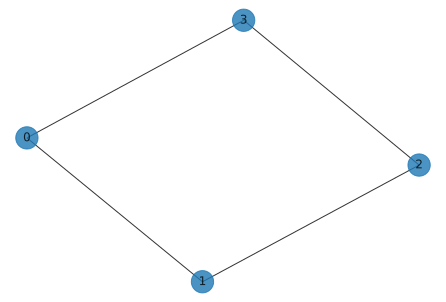

In [2]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

ম্যাক্স-কাট সমস্যার জন্য নির্দিষ্ট হ্যামিলটোনিয়ান সমস্যাটি একটি ধ্রুবক পর্যন্ত এখানে:

$$ H_P = \frac{1}{2}\big(Z_0 \otimes Z_1 \otimes I_2 \otimes I_3\big) + \frac{1}{2}\big(I_0 \otimes Z_1 \otimes Z_2 \otimes I_3\big) + \frac{1}{2}\big(Z_0 \otimes I_1 \otimes I_2 \otimes Z_3\big) + \frac{1}{2}\big(I_0 \otimes I_1 \otimes Z_2 \otimes Z_3\big) $$

একটি সমস্যার জন্য এই ধরনের একটি হ্যামিল্টোনিয়ান তৈরি করতে, একজনকে কয়েকটি পদক্ষেপ অনুসরণ করতে হবে যা আমরা এই পৃষ্ঠার পরবর্তী বিভাগে কভার করব।

মিক্সার হ্যামিলটোনিয়ান $H_B$ সাধারণত ফর্মের হয়:

$$ H_B = \big(X_0 \otimes I_1 \otimes I_2 \otimes I_3 \big) + \big(I_0 \otimes X_1 \otimes I_2 \otimes I_3 \big) + \big(I_0 \otimes I_1 \otimes X_2 \otimes I_3 \big) + \big(I_0 \otimes I_1 \otimes I_2 \otimes X_3 \big) $$

$H_P$ এবং $H_B$ উভয় যাতায়াতের সমষ্টিতে পৃথক পদ হিসাবে, আমরা ইউনিটারিগুলিকে এইভাবে লিখতে পারি:

$$ U(H_B) = e^{-i \beta H_B} = e^{-i \beta X_0}e^{-i \beta X_1}e^{-i \beta X_2}e^{-i \beta X_3}.$$

লক্ষ্য করুন যে উপরের পণ্যের প্রতিটি পদ প্রতিটি কিউবিটের একটি X-ঘূর্ণনের সাথে মিলে যায়। এবং আমরা $U(H_P)$ এভাবে লিখতে পারি:

$$ U(H_P) = e^{-i \gamma H_P} = e^{-i \gamma Z_0 Z_1}e^{-i \gamma Z_1 Z_2}e^{-i \gamma Z_2 Z_3}e^{-i \gamma Z_0 Z_3}$$

এখন দুই ইউনিটির সার্কিট কেমন তা পরীক্ষা করা যাক। 

### মিক্সিং ইউনিটারি

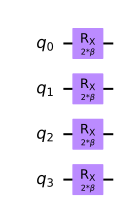

In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw()

### সমস্যা একক

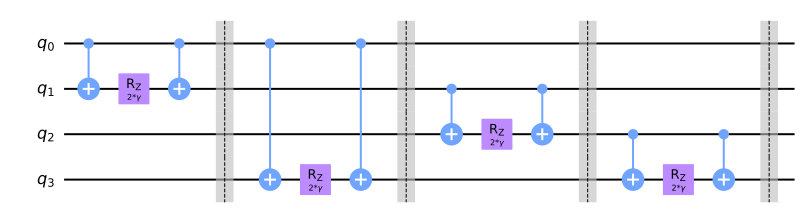

In [4]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw()

### প্রাথমিক অবস্থা

QAOA এর সময় ব্যবহৃত প্রাথমিক অবস্থাটি সাধারণত সমস্ত ভিত্তি স্টেটের সমান সুপারপজিশন হয়

$$\lvert \psi_0 \rangle = \bigg(\frac{1}{\sqrt{2}}\big(\lvert 0 \rangle + \lvert 1 \rangle\big)\bigg)^{\otimes n}$$

এই জাতীয় অবস্থা, যখন কিউবিটের সংখ্যা 4 ($n=4$), নীচের সার্কিটে দেখানো হিসাবে একটি সমস্ত শূন্য অবস্থা থেকে শুরু করে হাদামার্ড গেটগুলি প্রয়োগ করে প্রস্তুত করা যেতে পারে। 

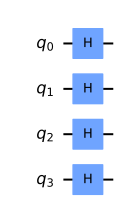

In [5]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw()

### QAOA সার্কিট

এ পর্যন্ত আমরা দেখেছি যে QAOA এর সময় একটি কোয়ান্টাম অবস্থার প্রস্তুতি তিনটি উপাদানের সমন্বয়ে গঠিত

- একটি প্রাথমিক অবস্থা প্রস্তুত করা হচ্ছে
- একক `{latex} U(H_P) = e^{-i \gamma H_P}` প্রয়োগ করা হচ্ছে হ্যামিলটোনিয়ান সমস্যার সাথে সম্পর্কিত
- তারপর, মিশ্রণ একক প্রয়োগ করা হচ্ছে `{latex} U(H_B) = e^{-i \beta H_B}`

উদাহরণ সমস্যাটির জন্য এটি দেখতে কেমন তা দেখা যাক:

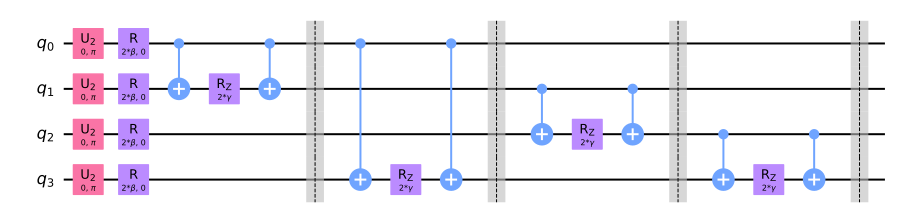

In [6]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()

পরবর্তী ধাপ হল সর্বোত্তম পরামিতি খুঁজে পাওয়া `{latex} (\boldsymbol{\beta_{\text{opt}}}, \boldsymbol{\gamma_{\text{opt}}})` যাতে প্রত্যাশার মান

$$ \langle \psi(\boldsymbol{\beta}*{\text{opt}}, \boldsymbol{\gamma}*{\text{opt}}) \rvert H_P \lvert \psi(\boldsymbol{\beta}*{\text{opt}}, \boldsymbol{\gamma}*{\text{opt}}) \rangle $$

ছোট করা হয়। Z-ভিত্তিতে পরিমাপ করে এমন প্রত্যাশা পাওয়া যেতে পারে। আমরা সর্বোত্তম পরামিতি খুঁজে পেতে একটি ক্লাসিক্যাল অপ্টিমাইজেশান অ্যালগরিদম ব্যবহার করি। পরিকল্পনায় দেখানো হিসাবে নিম্নলিখিত পদক্ষেপগুলি জড়িত

<img src="images/QAOA_schematic.png" width="400" height="200" class="center">

1. উপযুক্ত বাস্তব মানের জন্য $\boldsymbol{\beta}$ এবং $\boldsymbol{\gamma}$ শুরু করুন।
2. কিছু উপযুক্ত কনভারজেন্স মানদণ্ড পূরণ না হওয়া পর্যন্ত পুনরাবৃত্তি করুন:
    1. qaoa সার্কিট ব্যবহার করে $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$ প্রস্তুত করুন
    2. মান ভিত্তিতে রাষ্ট্র পরিমাপ
    3. গণনা $ \langle \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rvert H_P \lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle $
    4. ক্লাসিক্যাল অপ্টিমাইজেশান অ্যালগরিদম ব্যবহার করে নতুন প্যারামিটারের সেট খুঁজুন `{latex} (\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})`
    5. বর্তমান প্যারামিটার $(\boldsymbol{\beta}, \boldsymbol{\gamma})$ সেট করুন নতুন প্যারামিটারের সমান `{latex} (\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})`

নীচের কোডটি উপরে উল্লিখিত পদক্ষেপগুলি বাস্তবায়ন করে।

In [7]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [8]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res

     fun: -2.994140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.9793337 , 1.16663483])

উল্লেখ্য যে ক্লাসিক্যাল অপ্টিমাইজারের বিভিন্ন পছন্দ কিস্কিট-এ উপস্থিত রয়েছে। আমরা এখানে আমাদের ক্লাসিক্যাল অপ্টিমাইজেশান অ্যালগরিদম হিসাবে [COBYLA](https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/algorithms/optimizers/cobyla.py) বেছে নিয়েছি।

### ফলাফল বিশ্লেষণ

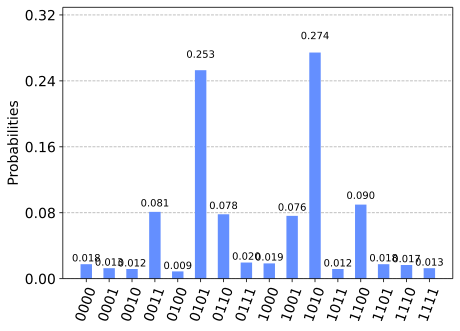

In [9]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

আমরা লক্ষ্য করেছি যে "0101" এবং "1010" বিটস্ট্রিংগুলির সর্বাধিক সম্ভাবনা রয়েছে এবং প্রকৃতপক্ষে গ্রাফের অ্যাসাইনমেন্ট (আমরা শুরু করেছি) যা দুটি পার্টিশনের মধ্যে 4টি প্রান্ত দেয়। 

## পরিশিষ্ট

### 1. নির্মাণ সমস্যা হ্যামিলটোনিয়ান<a id="Constructing Hamiltonian"></a>

যেকোন সর্বাধিকীকরণ সমস্যা একটি ন্যূনতমকরণ সমস্যার পরিপ্রেক্ষিতে এবং তদ্বিপরীতভাবে নিক্ষেপ করা যেতে পারে। তাই সাধারণ ফর্ম একটি সমন্বয় অপ্টিমাইজেশান সমস্যা দ্বারা দেওয়া হয়

$$ \text{maximize } ;;      C(x)$$

$$ \text{subject to } ;; x \in S $$

যেখানে $x \in S$, একটি বিচ্ছিন্ন পরিবর্তনশীল এবং $C : D \rightarrow \mathbb{R}$ হল খরচ ফাংশন, যা কিছু ডোমেন $S$ থেকে বাস্তব সংখ্যা $\mathbb{R}$-এ ম্যাপ করে . ভেরিয়েবল $x$ সীমাবদ্ধতার একটি সেটের সাপেক্ষে হতে পারে এবং সম্ভাব্য পয়েন্টগুলির $S \subset D$ এর মধ্যে অবস্থিত।

বাইনারি কম্বিনেটরিয়াল অপ্টিমাইজেশান সমস্যায়, খরচ ফাংশন $C$ সাধারণত এমন পদগুলির যোগফল হিসাবে প্রকাশ করা যেতে পারে যেগুলি $x \in {0 স্ট্রিং-এ $n$ বিটের একটি উপসেট $Q \subset[n]$ জড়িত থাকে, 1}^n$ এবং ক্যানোনিকাল আকারে লেখা হয়

$$ C(x) = \sum_{(Q,\overline{Q}) \subset [n]} w_{(Q,\overline{Q})} ; \prod_{i\in Q} x_i ; \prod_{j\in \overline{Q}} (1- x_j), $$

যেখানে $x_i \in {0,1}$ এবং $w_{(Q,\overline{Q})}\in \mathbb{R}$। আমরা n-বিট স্ট্রিং $x$ খুঁজে পেতে চাই যার জন্য $C(x)$ সর্বাধিক।

#### 1.1 তির্যক হ্যামিল্টোনিয়ান

এই খরচ ফাংশন একটি হ্যামিল্টোনিয়ান ম্যাপ করা যেতে পারে যা গণনাগত ভিত্তিতে তির্যক। Cost-functionদেওয়া $C$ এই হ্যামিলটোনিয়ান তারপর হিসাবে লেখা হয়

$$ H = \sum_{x \in {0,1}^n} C(x) |x \rangle\langle x| $$

যেখানে $x \in {0,1}^n$ লেবেল কম্পিউটেশনাল ভিত্তিতে $|x \rangle \in \mathbb{C}^{2^n}$ বলে। যদি Cost-function শুধুমাত্র সর্বাধিক ওজন $k$ পদ থাকে, অর্থাৎ যখন শুধুমাত্র $Q$ অবদান রাখে যা সর্বাধিক $Q \leq k$ বিটগুলি জড়িত, তাহলে এই তির্যক হ্যামিলটোনিয়ানটিও শুধুমাত্র $k$ পাউলি $Z ওজনের সমষ্টি। $ অপারেটর।

পাওলি $Z$ অপারেটরগুলিতে $H$-এর সম্প্রসারণ প্রতিটি বাইনারি ভেরিয়েবল $x_i \in {0,1}$ ম্যাট্রিক্স `{latex} x_i \rightarrow 2^{-1}(1 - Z_i)` এর প্রতিস্থাপনের মাধ্যমে $C$-এর মূল্য-ফাংশনের ক্যানোনিকাল সম্প্রসারণ থেকে প্রাপ্ত করা যেতে পারে। <code>{latex} x_i \rightarrow 2^{-1}(1 - Z_i)</code> । এখানে $Z_i$ কে পাউলি $Z$ অপারেটর হিসাবে পড়া হয়েছে যা qubit $i$ এ কাজ করে এবং অন্য সকলের উপর তুচ্ছ, যেমন

$$ Z_i = \left(\begin{array}{cc} 1 &amp; 0 \ 0 &amp; -1 \end{array}\right). $$

এর মানে হল যে স্পিন হ্যামিলটোনিয়ান এনকোডিং ক্লাসিক্যাল খরচ ফাংশন একটি $|Q|$ - স্থানীয় কোয়ান্টাম স্পিন হ্যামিলটোনিয়ান শুধুমাত্র পাউলি $Z$- অপারেটরদের সাথে জড়িত।

$$ H = \sum_{(Q,\overline{Q}) \subset [n]} w_{(Q,\overline{Q})} ; \frac{1}{2^{|Q| + |\overline{Q}|}}\prod_{i\in Q} \left(1 - Z_i\right) ; \prod_{j\in \overline{Q}} \left(1 + Z_j\right).$$

এখন, আমরা অনুমান করব যে শুধুমাত্র কয়েকটি ($n$-এ বহুপদে অনেকগুলি) $w_{(Q,\overline{Q})}$ হবে অ-শূন্য। তাছাড়া আমরা ধরে নেব যে $|(Q,\overline{Q})|$ সেটটি আবদ্ধ এবং খুব বড় নয়। এর মানে হল আমরা cost ফাংশনের পাশাপাশি হ্যামিলটোনিয়ান $H$ লিখতে পারি $m$ স্থানীয় পদ $\hat{C}_k$,

$$ H = \sum_{k = 1}^m \hat{C}_k, $$

যেখানে $m$ এবং $\hat{C}_k$-এর সমর্থন উভয়ই যুক্তিসঙ্গতভাবে আবদ্ধ।

### 2 উদাহরণ:<a id="examples"></a>

সমন্বিত অপ্টিমাইজেশান সমস্যাগুলি ব্যাখ্যা করার জন্য আমরা 2টি উদাহরণ বিবেচনা করি৷ আমরা কিস্কিটের মতো প্রথম উদাহরণটি বাস্তবায়ন করব, তবে অনুশীলনের একটি ক্রম সরবরাহ করব যা দ্বিতীয় উদাহরণটিও বাস্তবায়নের নির্দেশনা দেয়।

#### 2.1 (weighted) $MAXCUT$

একটি $n$-নোড অ-নির্দেশিত গ্রাফ *G = (V, E)* যেখানে *|V|* বিবেচনা করুন <em>= n</em> প্রান্তের ওজন $w_{ij}&gt;0$, <code>{latex} w_{ij}=w_{ji}</code> , $(i,j)\E$-এর জন্য। একটি কাটকে মূল সেট V-এর দুটি উপসেটে বিভাজন হিসাবে সংজ্ঞায়িত করা হয়। এই ক্ষেত্রে অপ্টিমাইজ করা খরচ ফাংশন হল দুটি ভিন্ন উপসেটে প্রান্ত সংযোগ বিন্দুর ওজনের সমষ্টি, কাটা <em>অতিক্রম</em> করা। প্রতিটি নোড $i$-এ $x_i=0$ বা $x_i=1$ বরাদ্দ করে, একজন বিশ্বব্যাপী লাভ ফাংশন সর্বাধিক করার চেষ্টা করে (এখানে এবং নিম্নলিখিত সারাংশে সূচক 1,2,...,n এর উপরে চলে)

$$C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1-x_j).$$

স্বরলিপি সহজ করার জন্য, আমরা $(i,j) \ E$ এর জন্য অভিন্ন ওজন $w_{ij} = 1$ ধরে নিই। একটি কোয়ান্টাম কম্পিউটারে এই সমস্যার সমাধান খুঁজতে, প্রথমে এটিকে উপরে আলোচিত একটি তির্যক হ্যামিলটোনিয়ানে ম্যাপ করতে হবে। আমরা $(i,j) = E$ সেটে প্রান্তের উপর সমষ্টি হিসাবে যোগফল লিখি

$$C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1-x_j)  = \sum_{(i,j) \in E} \left( x_i (1-x_j) + x_j (1-x_i)\right)$$

এটিকে একটি স্পিন হ্যামিলটোনিয়ানে ম্যাপ করতে, আমরা অ্যাসাইনমেন্ট করি `{latex} x_i\rightarrow (1-Z_i)/2` , যেখানে $Z_i$ হল পাওলি Z অপারেটর যার eigenvalues $\pm 1$ এবং $X \rightarrow H প্রাপ্ত $

$$ H = \sum_{(j,k) \in E} \frac{1}{2}\left(1 - Z_j Z_k \right).$$

এর মানে হল যে হ্যামিলটোনিয়ানকে $m = |E|$ স্থানীয় পদগুলির যোগফল হিসাবে লেখা যেতে পারে:

$$\hat{C}*e = \frac{1}{2}\left(1 - Z*<e>Z_<e>\right)$$</e></e>

সঙ্গে $e = (e1,e2) \in E$।

#### 2.2 সীমাবদ্ধতা সন্তুষ্টি সমস্যা এবং $\text{MAX 3-SAT}$।

একটি সমন্বিত অপ্টিমাইজেশন সমস্যার আরেকটি উদাহরণ হল $\text{3-SAT}$। এখানে খরচ ফাংশন `{latex} C(\textbf{x}) = \sum_{k = 1}^m c_k(\textbf{x})` হল $c_k(\textbf{x})$ যে সীমাবদ্ধ কিছু $\textbf{x} এর $3$ বিটের মান {0,1}^n$ যে ধারায় অংশগ্রহণ করে। উদাহরণ স্বরূপ একটি $\text{3-SAT}$ ধারার এই উদাহরণটি বিবেচনা করুন

$$ c_1(\textbf{x}) = (1-x_1)(1-x_3)x_{132} $$

একটি বিট স্ট্রিং $\textbf{x} \ in {0,1}^{133}$। ধারাটি শুধুমাত্র $x_1 = 0$,$x_3 = 0$ এবং $x_{132} = 1$ সেট করেই সন্তুষ্ট হতে পারে। $\text{3-SAT}$ সমস্যাটি এখন জিজ্ঞাসা করে যে এমন একটি বিট স্ট্রিং আছে যা $m$ ক্লজগুলির সবগুলিকে সন্তুষ্ট করে বা এরকম কোনও স্ট্রিং বিদ্যমান নেই কিনা। এই সিদ্ধান্ত সমস্যা হল একটি সমস্যার প্রধান উদাহরণ যা $NP$-সম্পূর্ণ।

ঘনিষ্ঠভাবে সম্পর্কিত অপ্টিমাইজেশান সমস্যা $\text{MAX 3-SAT}$ বিট স্ট্রিং $\textbf{x}$ খুঁজতে বলে যা $C(\textbf{x})$-এ সর্বাধিক সংখ্যক ধারাকে সন্তুষ্ট করে। এটি অবশ্যই একটি সিদ্ধান্তের সমস্যায় পরিণত হতে পারে যদি আমরা জিজ্ঞাসা করি যেখানে একটি বিট স্ট্রিং আছে যা $m$ ধারাগুলির $\tilde{m}$-এর বেশি সন্তুষ্ট করে, যা আবার $NP$-সম্পূর্ণ।

### 3. আনুমানিক অপ্টিমাইজেশান অ্যালগরিদম<a id="approximateOPT"></a>

পূর্বে বিবেচনা করা উভয় সমস্যা $MAXCUT$ এবং $\text{MAX 3-SAT}$ আসলে একটি NP-হার্ড সমস্যা [3](#references) হিসাবে পরিচিত। প্রকৃতপক্ষে দেখা যাচ্ছে যে অনেক সমন্বিত অপ্টিমাইজেশান সমস্যা গণনাগতভাবে সাধারণভাবে সমাধান করা কঠিন। এই সত্যের আলোকে, আমরা একটি প্রমাণযোগ্যভাবে দক্ষ অ্যালগরিদম খুঁজে পাওয়ার আশা করতে পারি না, অর্থাৎ সমস্যা আকারে বহুপদী রানটাইম সহ একটি অ্যালগরিদম, যা এই সমস্যার সমাধান করে। এটি কোয়ান্টাম অ্যালগরিদমের ক্ষেত্রেও প্রযোজ্য। এই ধরনের সমস্যা মোকাবেলা করার জন্য দুটি প্রধান পন্থা আছে। প্রথম পদ্ধতি হল আনুমানিক অ্যালগরিদম যা বহুপদী সময়ে নির্দিষ্ট মানের সমাধান খুঁজে পাওয়ার নিশ্চয়তা দেয়। দ্বিতীয় পন্থা হল হিউরিস্টিক অ্যালগরিদম যার কোনো বহুপদী রানটাইম গ্যারান্টি নেই কিন্তু এই ধরনের সমস্যার কিছু ক্ষেত্রে ভালো পারফরমেন্স দেখায়।

আনুমানিক অপ্টিমাইজেশান অ্যালগরিদমগুলি দক্ষ এবং একটি প্রমাণযোগ্য গ্যারান্টি প্রদান করে যে আনুমানিক সমাধানটি সমস্যার প্রকৃত সর্বোত্তমতার কতটা কাছাকাছি। গ্যারান্টিটি সাধারণত একটি আনুমানিক অনুপাতের আকারে আসে, $\alpha \leq 1$। একটি সম্ভাব্য আনুমানিক অপ্টিমাইজেশান অ্যালগরিদম গ্যারান্টি দেয় যে এটি একটি বিট-স্ট্রিং $\textbf{x}^* \in {0,1}^n$ তৈরি করে যাতে *উচ্চ সম্ভাবনার সাথে* আমাদের কাছে এটি একটি ধনাত্মক `{latex} C_\text{max} = \max_{\textbf{x}}C(\textbf{x})`

$$ C_\text{max} \geq C(\textbf{x}^*) \geq \alpha C_\text{max}. $$

$MAXCUT$ সমস্যার জন্য Goemans এবং Williamson [2](#references) এর কারণে একটি বিখ্যাত আনুমানিক অ্যালগরিদম রয়েছে। এই অ্যালগরিদমটি একটি সম্ভাব্য রাউন্ডিং কৌশলের সাথে মিলিত মূল সমস্যার একটি SDP শিথিলতার উপর ভিত্তি করে তৈরি করা হয়েছে যা উচ্চ সম্ভাবনার আনুমানিক সমাধান $\textbf{x}^*$ দেয় যার আনুমানিক অনুপাত রয়েছে $\alpha \ প্রায় 0.878$। এই আনুমানিক অনুপাতটি আসলে সর্বোত্তম বলে বিশ্বাস করা হয় তাই আমরা একটি কোয়ান্টাম অ্যালগরিদম ব্যবহার করে উন্নতি দেখতে আশা করি না।

### 4. QAOA অ্যালগরিদম<a id="QAOA"></a>

ফারহি, গোল্ডস্টোন এবং গুটম্যান [1](#references) এর কোয়ান্টাম আনুমানিক অপ্টিমাইজেশান অ্যালগরিদম (QAOA) একটি হিউরিস্টিক অ্যালগরিদমের উদাহরণ। Goemans-Williamson অ্যালগরিদমের বিপরীতে, QAOA কর্মক্ষমতা গ্যারান্টি দিয়ে আসে না। QAOA ক্লাসিক্যাল আনুমানিক অ্যালগরিদমগুলির পদ্ধতি গ্রহণ করে এবং একটি কোয়ান্টাম অ্যানালগ সন্ধান করে যা একইভাবে একটি ক্লাসিক্যাল বিট স্ট্রিং $x^*$ তৈরি করবে যার উচ্চ সম্ভাবনার সাথে একটি ভাল আনুমানিক অনুপাত $\alpha$ হবে বলে আশা করা হয়। বিস্তারিত আলোচনা করার আগে, প্রথমে এই পদ্ধতির সাধারণ ধারণা উপস্থাপন করা যাক।

#### 4.1 ওভারভিউ:

আমরা একটি কোয়ান্টাম অবস্থা খুঁজে পেতে চাই $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$, যা কিছু বাস্তব পরামিতির উপর নির্ভর করে $\vec{\gamma},\vec{\beta} \in \mathbb{R}^p$, যার বৈশিষ্ট্য রয়েছে যে এটি হ্যামিলটোনিয়ান $H$ সমস্যার ক্ষেত্রে প্রত্যাশার মানকে সর্বাধিক করে তোলে। এই ট্রায়াল স্টেটটির প্রেক্ষিতে আমরা $\vec{\gamma}^ *,\vec{\beta}^* $ সার্চ করি যা সর্বাধিক `{latex} F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle` ।

একবার আমাদের এমন একটি অবস্থা এবং সংশ্লিষ্ট পরামিতিগুলি পাওয়া গেলে আমরা একটি কোয়ান্টাম কম্পিউটারে $|\psi_p(\vec{\gamma}^ *,\vec{\beta}^* )\rangle$ প্রস্তুত করি এবং $Z-এ রাজ্যটি পরিমাপ করি। $ ভিত্তি `{latex} |x \rangle = |x_1,\ldots x_n \rangle` একটি এলোমেলো ফলাফল $x^*$ পেতে।

আমরা দেখতে পাব যে এই এলোমেলো $x^ *$ একটি বিট স্ট্রিং হতে চলেছে যা প্রত্যাশিত মানের কাছাকাছি উচ্চ সম্ভাবনা সহ `{latex} M_p = F_p(\vec{\gamma}^*,\vec{\beta}^*)` । তাই, যদি $M_p$ $C_\text{max}$ এর কাছাকাছি হয় তাহলে $C(x^* )$ হয়।

#### 4.2 QAOA অ্যালগরিদমের উপাদান।

#### 4.2.1 QAOA ট্রায়াল স্টেট<a id="section_421"></a>

QAOA এর কেন্দ্রীয় হল ট্রায়াল স্টেট $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ যা কোয়ান্টাম কম্পিউটারে প্রস্তুত করা হবে। আদর্শভাবে আমরা চাই যে এই রাজ্যটি একটি বৃহৎ প্রত্যাশার মানের জন্ম দেবে `{latex} F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle` হ্যামিলটোনিয়ান $H$ এর ক্ষেত্রে। ফার্হি [1](#references) -এ, ট্রায়ালে বলা হয়েছে $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ একক কিউবিট পাওলি $X$ ঘূর্ণন সহ হ্যামিলটোনিয়ান $H$ সমস্যা থেকে তৈরি করা হয়েছে। এর মানে, একটি সমস্যা দেওয়া হ্যামিলটনিয়ান

$$ H = \sum_{k = 1}^m \hat{C}_k $$

কম্পিউটেশনাল ভিত্তিতে তির্যক এবং একটি তির্যক ক্ষেত্র হ্যামিলটোনিয়ান

$$ B = \sum_{i = 1}^n X_i $$

$p$ বিকল্প ইউনিটারি প্রয়োগ করে ট্রায়াল স্টেট প্রস্তুত করা হয়

$$ |\psi_p(\vec{\gamma},\vec{\beta})\rangle = e^{ -i\beta_p B } e^{ -i\gamma_p H } \ldots e^{ -i\beta_1 B } e^{ -i\gamma_1 H } |+\rangle^n $$

$ X |+\rangle = |+\rangle$ সহ $|+\rangle^n$ পণ্যের অবস্থাতে।

এই বিশেষ ansatz-এর সুবিধা রয়েছে যে ভেক্টরগুলির জন্য একটি স্পষ্ট পছন্দ রয়েছে $\vec{\gamma}^ *,\vec{\beta}^* $ যেমন `{latex} M_p = F_p(\vec{\gamma}^*,\vec{\beta}^*)` জন্য `{latex} M_p = F_p(\vec{\gamma}^*,\vec{\beta}^*)` যখন আমরা সীমা নিই <code>{latex} \lim_{p \rightarrow \infty} M_p = C_\text{max}</code> । এটি ট্রায়াল স্টেট $|\psi_p(\vec{\gamma},\vec{\beta}) \rangle$ দেখে অনুসরণ করে যেটি $H$ এবং ট্রান্সভার্স ফিল্ড হ্যামিলটোনিয়ানের ক্ষেত্রে অ্যাডিয়াব্যাটিক বিবর্তনকে ট্রটারাইজ করা থেকে অনুসরণ করে। $B$, cf রেফারেন্স <a>1</a> ।

বিপরীতভাবে এই ট্রায়াল স্টেটের অসুবিধা হল যে কেউ সাধারণত এমন একটি স্টেট চাইবে যা একটি কোয়ান্টাম সার্কিট থেকে তৈরি করা হয়েছে যা খুব গভীর নয়। এখানে গভীরতা পরিমাপ করা হয় গেটগুলির সাপেক্ষে যা সরাসরি কোয়ান্টাম চিপে প্রয়োগ করা যেতে পারে। তাই অন্যান্য প্রস্তাবগুলি রয়েছে যা Ansatz ট্রায়াল স্টেট ব্যবহার করার পরামর্শ দেয় যা কোয়ান্টাম চিপ রেফের হার্ডওয়্যারের সাথে আরও উপযোগী। [4](#references) , রেফারি. [5](#references)

#### 4.2.2 প্রত্যাশা মান গণনা করা<a id="section_422"></a>

এই পদ্ধতির একটি গুরুত্বপূর্ণ উপাদান হল আমাদের প্রত্যাশা মান গণনা বা অনুমান করতে হবে

$$ F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle $$

তাই আমরা $\vec{\gamma},\vec{\beta}$ পরামিতি অপ্টিমাইজ করতে পারি। আমরা এখানে দুটি পরিস্থিতিতে বিবেচনা করা হবে.

#### ক্লাসিক্যাল মূল্যায়ন

মনে রাখবেন যে যখন $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ প্রস্তুত করার জন্য সার্কিটটি খুব বেশি গভীর না হয় তখন প্রত্যাশার মান $F_p$ ক্লাসিকভাবে মূল্যায়ন করা সম্ভব হতে পারে।

উদাহরণস্বরূপ এটি ঘটে যখন কেউ বাউন্ডেড ডিগ্রী সহ গ্রাফের জন্য $MAXCUT$ বিবেচনা করে এবং কেউ $p=1$ সহ একটি সার্কিট বিবেচনা করে। আমরা নীচের কিস্কিট বাস্তবায়নে এর একটি উদাহরণ দেখতে পাব (বিভাগ 5.2) এবং প্রত্যাশার মান গণনা করার জন্য একটি অনুশীলন প্রদান করব।

ধারণাটি ব্যাখ্যা করার জন্য, স্মরণ করুন যে হ্যামিলটোনিয়ানকে পৃথক পদের যোগফল হিসাবে লেখা যেতে পারে `{latex} H = \sum_{k = 1}^m \hat{C}_k` । প্রত্যাশা মানের রৈখিকতার কারণে, পৃথক সমষ্টিগুলির প্রত্যাশার মান বিবেচনা করা যথেষ্ট। $p = 1$ এর জন্য এটি আছে

$$ \langle \psi_1(\vec{\gamma},\vec{\beta})|\hat{C}_k|\psi_1(\vec{\gamma},\vec{\beta})\rangle = \ ল্যাঙ্গেল +^n | e^{ i\gamma_1 H } e^{ i\beta_1 B } | \hat{C}_k | e^{ -i\beta_1 B } e^{ -i\gamma_1 H } |+^n\rangle.$$

লক্ষ্য করুন যে `{latex} B = \sum_{i = 1}^n X_i` একক $e^{ -i\beta_1 B }$ প্রকৃতপক্ষে $X$ একটি কোণ $\beta$ সহ একক কিউবিট ঘূর্ণনের একটি গুণফল। যার জন্য আমরা লিখব `{latex} X(\beta)_k = \exp(i\beta X_k)` ।

সমস্ত স্বতন্ত্র ঘূর্ণন যেগুলি কিউবিটগুলিতে কাজ করে না যেখানে $\hat{C}_k$ সমর্থিত $\hat{C}_k$ এর সাথে যাতায়াত এবং সেইজন্য বাতিল। এটি অপারেটর $\hat{C}_k$ এর সমর্থন বাড়ায় না। এর মানে হল যে একক গেটগুলির দ্বিতীয় সেট `{latex} e^{ -i\gamma_1 H } = \prod_{l=1}^m U_l(\gamma)` গেটগুলির একটি বড় সেট আছে `{latex} U_l(\gamma) = e^{ -i\gamma_1 \hat{C}_l }` যা অপারেটরের সাথে যাতায়াত করে `{latex} e^{ i\beta_1 B } \hat{C}_k e^{ -i\beta_1 B }` । একমাত্র গেট `{latex} U_l(\gamma) = e^{ -i\gamma_1 \hat{C}_l }` যেগুলি প্রত্যাশার মূল্যে অবদান রাখে সেগুলি হল মূল $\hat{C}_k-এর সমর্থনে qubits জড়িত $

তাই, আবদ্ধ ডিগ্রি ইন্টারঅ্যাকশনের জন্য `{latex} e^{ i\gamma_1 H } e^{ i\beta_1 B } \hat{C}_k e^{ -i\beta_1 B } e^{ -i\gamma_1 H }` শুধুমাত্র $H$-এ ইন্টারঅ্যাকশনের ডিগ্রী দ্বারা প্রদত্ত পরিমাণ দ্বারা প্রসারিত হয় এবং তাই সিস্টেমের আকার থেকে স্বাধীন। এর মানে হল যে এই ছোট সাব সমস্যার জন্য প্রত্যাশা মানগুলি $n$ থেকে স্বাধীন এবং ক্লাসিকভাবে মূল্যায়ন করা যেতে পারে। একটি সাধারণ ডিগ্রির ক্ষেত্রে $3$ [1](#references) এ বিবেচনা করা হয়।

এটি একটি সাধারণ পর্যবেক্ষণ, যার মানে হল যে যদি আমাদের একটি সমস্যা হয় যেখানে ট্রায়াল স্টেট প্রস্তুতির জন্য ব্যবহৃত সার্কিট শুধুমাত্র হ্যামিলটোনিয়ানের প্রতিটি শব্দের সমর্থনকে একটি ধ্রুবক পরিমাণ দ্বারা বৃদ্ধি করে খরচ ফাংশন সরাসরি মূল্যায়ন করা যেতে পারে।

যখন এটি হয়, এবং মাত্র কয়েকটি পরামিতি $\beta, \gamma$ ট্রায়াল স্টেটের প্রস্তুতির জন্য প্রয়োজন হয়, তখন একটি সাধারণ গ্রিড অনুসন্ধানের মাধ্যমে এইগুলি সহজেই পাওয়া যেতে পারে। অধিকন্তু, আনুমানিক অনুপাতকে আবদ্ধ করতে $M_p$ এর একটি সঠিক সর্বোত্তম মান ব্যবহার করা যেতে পারে

$$ \frac{M_p}{C_\text{max}} \geq \alpha $$

$\alpha$ এর একটি অনুমান প্রাপ্ত করতে। এই ক্ষেত্রে QAOA অ্যালগরিদমের একটি প্রচলিত আনুমানিক অপ্টিমাইজেশান অ্যালগরিদমের মতো একই বৈশিষ্ট্য রয়েছে যা একটি গ্যারান্টিযুক্ত আনুমানিক অনুপাতের সাথে আসে যা সমস্যা আকারে বহুপদী দক্ষতার সাথে প্রাপ্ত করা যেতে পারে।

#### একটি কোয়ান্টাম কম্পিউটারে মূল্যায়ন

যখন কোয়ান্টাম সার্কিট ক্লাসিকভাবে মূল্যায়ন করার জন্য খুব গভীর হয়ে যায়, বা যখন সমস্যা হ্যামিলটোনিয়ানের সংযোগ খুব বেশি হয় তখন আমরা প্রত্যাশা মান অনুমান করার অন্যান্য উপায় অবলম্বন করতে পারি। এতে কোয়ান্টাম কম্পিউটারে সরাসরি $F_p(\vec{\gamma},\vec{\beta})$ অনুমান করা জড়িত। এখানে পদ্ধতিটি VQE [4](#references) -এ ব্যবহৃত প্রচলিত প্রত্যাশা মান অনুমানের পথ অনুসরণ করে, যেখানে একটি ট্রায়াল স্টেট $| \psi_p(\vec{\gamma},\vec{\beta}) \rangle$ সরাসরি কোয়ান্টাম কম্পিউটারে প্রস্তুত করা হয় এবং নমুনা থেকে প্রত্যাশার মান পাওয়া যায়।

যেহেতু QAOA-এর একটি তির্যক হ্যামিলটোনিয়ান $H$ আছে, এটি প্রকৃতপক্ষে প্রত্যাশার মান অনুমান করার জন্য সোজা। আমাদের শুধুমাত্র গণনামূলক ভিত্তিতে ট্রায়াল স্টেট থেকে নমুনা পেতে হবে। মনে করুন যে $H = \sum_{x \in {0,1}^n} C(x) |x \rangle\langle x|$ যাতে আমরা এর নমুনা অনুমান পেতে পারি

$$ \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle = \sum_{x \in {0,1}^n} C(x) |\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$$

রাষ্ট্রের বারবার একক কিউবিট পরিমাপের মাধ্যমে $| \psi_p(\vec{\gamma},\vec{\beta}) \Rangle $ $Z$ ভিত্তিতে। ডিস্ট্রিবিউশন থেকে প্রাপ্ত প্রতিটি বিট স্ট্রিং $x$ এর জন্য $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ আমরা মূল্য ফাংশন $C(x)$ মূল্যায়ন করি এবং নমুনার মোট সংখ্যার উপর এটি গড় করি। ফলাফলের অভিজ্ঞতামূলক গড় একটি সংযোজন নমুনা ত্রুটি পর্যন্ত প্রত্যাশার মানকে আনুমানিক করে যা রাষ্ট্রের ভিন্নতার মধ্যে থাকে। পার্থক্য নীচে আলোচনা করা হবে.

প্রত্যাশা মান অ্যাক্সেসের সাথে, আমরা এখন $F_p$ অপ্টিমাইজ করতে একটি ক্লাসিক্যাল অপ্টিমাইজেশান অ্যালগরিদম চালাতে পারি, যেমন [6](#references) ।

যদিও এই পদ্ধতিটি $x^*$-এর জন্য একটি অগ্রাধিকারের আনুমানিক গ্যারান্টির দিকে নিয়ে যায় না, অপ্টিমাইজ করা ফাংশন মান পরবর্তীতে আনুমানিক অনুপাত $\alpha$ এর জন্য একটি অনুমান প্রদান করতে ব্যবহার করা যেতে পারে।

#### 4.3.3 উচ্চ সম্ভাবনা সহ একটি প্রদত্ত আনুমানিক অনুপাত সহ একটি সমাধান প্রাপ্ত করা

অ্যালগরিদমটি সম্ভাব্য প্রকৃতির এবং ডিস্ট্রিবিউশন থেকে এলোমেলো বিট স্ট্রিং তৈরি করে $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$। তাহলে কিভাবে আমরা নিশ্চিত হতে পারি যে আমরা একটি আনুমানিক $x^*$ নমুনা করব যা অপ্টিমাইজ করা প্রত্যাশা মানের $M_p$ এর কাছাকাছি? মনে রাখবেন যে এই প্রশ্নটি প্রথম স্থানে একটি কোয়ান্টাম কম্পিউটারে $M_p$ এর অনুমানের সাথেও প্রাসঙ্গিক। যদি নমুনা $|\langle x| থেকে আঁকা হয় \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ এর খুব বেশি বৈচিত্র্য রয়েছে, গড় নির্ণয় করার জন্য অনেক নমুনা প্রয়োজন।

আমরা একটি বিট স্ট্রিং আঁকব $x^*$ যা গড় $M_p$ এর কাছাকাছি উচ্চ সম্ভাবনা সহ যখন পরিবর্তনশীল হিসাবে শক্তির সামান্য ভিন্নতা থাকে।

লক্ষ্য করুন যে হ্যামিলটোনিয়ান `{latex} H = \sum_{k=1}^m \hat{C}_k` এ পদের সংখ্যা $m$ দ্বারা সীমাবদ্ধ। বলুন প্রতিটি স্বতন্ত্র summand $\hat{C}_k$ এর একটি অপারেটর আদর্শ রয়েছে যা একটি সর্বজনীন ধ্রুবক $|\hat{C}_k| দ্বারা আবদ্ধ হতে পারে। সকল $k = 1\ldots m$ এর জন্য \leq \tilde{C}$। তারপর বিবেচনা করুন

$$ \begin{aligned} \langle \psi_p(\vec{\gamma},\vec{\beta})|H^2|\psi_p(\vec{\gamma},\vec{\beta})\rangle - \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle^2 &amp;\leq  \langle \psi_p(\vec{\gamma},\vec{\beta})|H^2|\psi_p(\vec{\gamma},\vec{\beta})\rangle \ &amp;= \sum_{k,l =1}^m  \langle \psi_p(\vec{\gamma},\vec{\beta})|\hat{C}_k \hat{C}_l |\psi_p(\vec{\gamma},\vec{\beta})\rangle \ &amp;\leq m^2 \tilde{C}^2 \ \end{aligned} $$

যেখানে আমরা ব্যবহার করেছি সেই `{latex} \langle \psi_p(\vec{\gamma},\vec{\beta})|\hat{C}_k \hat{C}_l |\psi_p(\vec{\gamma},\vec{\beta})\rangle \leq \tilde{C}^2` ।

এর মানে হল যে কোনো প্রত্যাশা $F_p(\vec{\gamma},\vec{\beta})$ $m^2 \tilde{C}^2$ দ্বারা আবদ্ধ। তাই এটি বিশেষ করে $M_p$ এর জন্য প্রযোজ্য। অধিকন্তু যদি $m$ শুধুমাত্র qubits $n$ সংখ্যায় বহুপদীভাবে বৃদ্ধি পায়, আমরা জানি যে বহুপদীভাবে ক্রমবর্ধমান নমুনা $s = O\left(\frac{\tilde{C}^2 m^2}{\epsilon) ^2}\right)$ থেকে $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ একটি $x^ *$ পাওয়ার জন্য যথেষ্ট হবে যা $C(x^ )$ এর দিকে নিয়ে যায় যা* $ এর কাছাকাছি হবে M_p$।

### 5. সমস্যা<a id="problems"></a>

1. QAOA অ্যালগরিদম একটি বিট স্ট্রিং তৈরি করে, এই স্ট্রিং কি এই গ্রাফের জন্য সর্বোত্তম সমাধান? স্থানীয় QASM সিমুলেশনের ফলাফলের সাথে সুপারকন্ডাক্টিং চিপ থেকে পরীক্ষামূলক ফলাফলের তুলনা করুন।

2. আমরা [বিভাগ 5.2](#implementation_sec52) এ বিশ্লেষণাত্মকভাবে $F_1$ খরচ ফাংশন গণনা করেছি। ধাপগুলি যাচাই করুন এবং $f_A(\gamma,\beta)$ এর পাশাপাশি $f_B(\gamma,\beta)$ গণনা করুন।

3. আমরা কিস্কিট বাস্তবায়নে $F_1$ এর জন্য একটি সঠিক অভিব্যক্তি দিয়েছি।

    - ফলাফলে প্রাপ্ত নমুনা থেকে প্রত্যাশার মান $F_1(\gamma,\beta)$ অনুমান করার জন্য একটি রুটিন লিখুন (ইঙ্গিত: [বিভাগ 5.4](#implementation_sec54) থেকে ফাংশন cost_function_C(x,G) ব্যবহার করুন এবং উভয় বিভাগে [5](#implementationsim) ডেটার মূল্যায়ন করুন <a>.a / 5.b</a> )

    - একটি অপ্টিমাইজেশন রুটিন ব্যবহার করুন, যেমন এই টিউটোরিয়ালে VQE উদাহরণ থেকে SPSA, নমুনাকৃত $F_1(\gamma,\beta)$-এ পরামিতিগুলিকে সংখ্যাগতভাবে অপ্টিমাইজ করতে। আপনি কি $\gamma^ *,\beta^* $ এর জন্য একই মান খুঁজে পান?

4. [অধ্যায় 5.3](#implementation_sec53) -এর ট্রায়াল সার্কিটটি গভীরতার সাথে মিলে যায় $p=1$ এবং সরাসরি হার্ডওয়্যারের সাথে সামঞ্জস্যপূর্ণ হওয়ার লক্ষ্য ছিল।

    - Use the routine from exercise 2 to evaluate the cost functions $F_p(\gamma,\beta)$ for $p=2,3$. What do you expect to see in the actual Hardware?
    - অন্যান্য প্রার্থী তরঙ্গ ফাংশন যেমন রেফ এর হার্ডওয়্যার দক্ষ ansatz হিসাবে ট্রায়াল অবস্থার এই শ্রেণীর সাধারণীকরণ. [4](#references)

5. উদাহরণ বিভাগে আলোচনা করা $\text{MAX 3-SAT}$-এর একটি উদাহরণ বিবেচনা করুন এবং সেই অনুযায়ী $F_p$ গণনা করতে আপনি ব্যবহার করেছেন [বিভাগ 5.4](#implementation_sec54) থেকে cost_function_C(c,G) ফাংশনটি পরিবর্তন করুন। হার্ডওয়্যার দক্ষ অ্যালগরিদম ব্যবহার করে $\text{MAX 3-SAT}$-এর এই উদাহরণের জন্য QAOA অ্যালগরিদম চালান এবং ফলাফলগুলি বিশ্লেষণ করুন৷ 

## তথ্যসূত্র<a id="references"></a>

1. Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint [arXiv:1411.4028 (2014)](https://arxiv.org/abs/1411.4028).
2. Goemans, Michel X., and David P. Williamson. [Journal of the ACM (JACM) 42.6 (1995): 1115-1145](http://www-math.mit.edu/~goemans/PAPERS/maxcut-jacm.pdf).
3. Garey, Michael R.; David S. Johnson (1979). Computers and Intractability: A Guide to the Theory of NP-Completeness. W. H. Freeman. ISBN 0-7167-1045-5
4. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." [Nature 549.7671 (2017): 242](https://www.nature.com/articles/nature23879).
5. Farhi, Edward, et al. "Quantum algorithms for fixed qubit architectures." arXiv preprint [arXiv:1703.06199 (2017)](https://arxiv.org/abs/1703.06199).
6. Spall, J. C. (1992), [IEEE Transactions on Automatic Control, vol. 37(3), pp. 332–341](https://ieeexplore.ieee.org/document/119632).
7. Michael Streif and Martin Leib "Training the quantum approximate optimization algorithm without access to a quantum processing unit" (2020) [Quantum Sci. Technol. 5 034008](https://doi.org/10.1088/2058-9565/ab8c2b)

In [10]:
import qiskit.tools.jupyter
%qiskit_version_table